In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import spiceypy
import sympy as sym
import math
import numpy.linalg as la
import scipy
import random
from scipy import linalg
from scipy import optimize
from astroquery.jplhorizons import Horizons

In [2]:
def jd2et(jd):
    """
    Converts Julian Date to JPL NAIF SPICE Ephemeris time.
    Only valid for TDB timescales.
    Parameters:
    -----------
    JD ... Modified Julian Day
    Returns:
    --------
    ET  ... Ephemeris time (ephemeris seconds beyond epoch J2000)
    """
    return (jd-2451545.0)*86400

def MtoE(e, M):
    """
    Converts mean anomaly to eccentric anomaly
    Parameters:
    -----------
    Mean anomaly, eccentricity
    Returns:
    --------
    Eccentric anomaly
    """
    def f(E):
        return E - e*np.sin(E) - M
    def fprime(E):
        return 1 - e*np.cos(E)
    root = scipy.optimize.newton(f, x0=1, fprime=fprime)
    return root

def kep2anglepairs(t0, kep, obs_times):
    """
    Converts keplerian element array to x,y,z coordinates and alpha, delta anglepairs
    Parameters:
    -----------
    Keplerian element array, time
    Returns:
    --------
    x,y,z coordinates and alpha, delta anglepairs
    """
    mu = 1.3271246207314793E+11
    n = len(obs_times)
    q = kep[0]*(1-kep[1])
    M = kep[5] - kep[1]*np.sin(kep[5]) # get mean anomaly from eccentric anomaly
    elts = np.hstack((q,kep[1:5],M,jd2et(t0),mu))
    xyz = []
    anglepairs = []
    for time in obs_times:
        coordinates = spiceypy.conics(elts, jd2et(time))
        x0 = coordinates[0]
        y0 = coordinates[1]
        z0 = coordinates[2]
        alpha = np.arctan2(y0, x0)
        delta = np.arcsin(z0 / (x0**2 + y0**2 + z0**2)**0.5)
        xyz.append([x0, y0, z0])
        anglepairs.append([alpha, delta])
    anglepairs = np.array(anglepairs)
    anglepairs.resize(2*n, 1)
    return xyz, anglepairs

#Partial derivative conversions for keplerian elements
def dalphada(x, y, a, e, I, omegaup, omegalow, E):
    dalphdx = -y / (x**2 + y**2)
    dxda = -np.sin(E)*(np.sqrt(1 - e**2))*(np.cos(omegaup)*np.sin(omegalow) + np.sin(omegaup)*np.cos(omegalow)*np.cos(I)) + (np.cos(E) - e)*(np.cos(omegaup)*np.cos(omegalow) - np.sin(omegaup)*np.sin(omegalow)*np.cos(I))
    return dalphdx*dxda

def dalphade(x, y, a, e, I, omegaup, omegalow, E):
    dalphdx = -y / (x**2 + y**2)
    dxde = a*(-np.cos(omegaup)*np.cos(omegalow) + np.sin(omegaup)*np.sin(omegalow)*np.cos(I) + np.sin(E)*(e / np.sqrt(1 - e**2))*(np.cos(omegaup)*np.sin(omegalow) + np.sin(omegaup)*np.cos(omegalow)*np.cos(I)))
    return dalphdx*dxde

def dalphadI(x, y, a, e, I, omegaup, omegalow, E):
    dalphdx = -y / (x**2 + y**2)
    dxdI = a*np.sin(omegaup)*np.sin(omegalow)*((np.sqrt(1 - e**2)) * np.cos(omegalow) * np.sin(E) + np.sin(omegalow)*(np.cos(E) - e))
    return dalphdx*dxdI

def dalphadomegaup(x, y, a, e, I, omegaup, omegalow, E):
    dalphdx = -y / (x**2 + y**2)
    dxdomegaup = a*((np.sin(omegaup)*np.sin(omegalow) - np.cos(omegaup)*np.cos(omegalow)*np.cos(I))*np.sin(E)*np.sqrt(1 - e**2) - (np.cos(E) - e)*(np.sin(omegaup)*np.cos(omegalow) + np.cos(omegaup)*np.sin(omegalow)*np.cos(I)))
    return dalphdx*dxdomegaup

def dalphadomegalow(x, y, a, e, I, omegaup, omegalow, E):
    dalphdx = -y / (x**2 + y**2)
    dxdomegalow = a*((-np.cos(omegaup)*np.cos(omegalow) + np.sin(omegaup)*np.sin(omegalow)*np.cos(I))*np.sin(E)*(np.sqrt(1 - e**2)) - (np.cos(E) - e) * (np.cos(omegaup)*np.sin(omegalow) + np.sin(omegaup)*np.cos(omegalow)*np.cos(I)))
    return dalphdx*dxdomegalow

def dalphadE(x, y, a, e, I, omegaup, omegalow, E):
    dalphdx = -y / (x**2 + y**2)
    dxdE = -a*((np.cos(omegaup)*np.sin(omegalow) + np.sin(omegaup)*np.cos(omegalow)*np.cos(I))*np.cos(E)*(np.sqrt(1 - e**2)) + np.sin(E)*(np.cos(omegaup)*np.cos(omegalow) - np.sin(omegaup)*np.sin(omegalow)*np.cos(I)))
    return dalphdx*dxdE

def ddeltada(x, y, z, a, e, I, omegaup, omegalow, E):
    ddeltdx = -(x*z) / ((np.sqrt(x**2 + y**2))*(x**2 + y**2 + z**2))
    dxda = -np.sin(E)*(np.sqrt(1 - e**2))*(np.cos(omegaup)*np.sin(omegalow) + np.sin(omegaup)*np.cos(omegalow)*np.cos(I)) + (np.cos(E) - e)*(np.cos(omegaup)*np.cos(omegalow) - np.sin(omegaup)*np.sin(omegalow)*np.cos(I))
    return ddeltdx*dxda

def ddeltade(x, y, z, a, e, I, omegaup, omegalow, E):
    ddeltdx = -(x*z) / ((np.sqrt(x**2 + y**2))*(x**2 + y**2 + z**2))
    dxde = a*(-np.cos(omegaup)*np.cos(omegalow) + np.sin(omegaup)*np.sin(omegalow)*np.cos(I) + np.sin(E)*(e / np.sqrt(1 - e**2))*(np.cos(omegaup)*np.sin(omegalow) + np.sin(omegaup)*np.cos(omegalow)*np.cos(I)))
    return ddeltdx*dxde

def ddeltadI(x, y, z, a, e, I, omegaup, omegalow, E):
    ddeltdx = -(x*z) / ((np.sqrt(x**2 + y**2))*(x**2 + y**2 + z**2))
    dxdI = a*np.sin(omegaup)*np.sin(omegalow)*((np.sqrt(1 - e**2)) * np.cos(omegalow) * np.sin(E) + np.sin(omegalow)*(np.cos(E) - e))
    return ddeltdx*dxdI

def ddeltadomegaup(x, y, z, a, e, I, omegaup, omegalow, E):
    ddeltdx = -(x*z) / ((np.sqrt(x**2 + y**2))*(x**2 + y**2 + z**2))
    dxdomegaup = a*((np.sin(omegaup)*np.sin(omegalow) - np.cos(omegaup)*np.cos(omegalow)*np.cos(I))*np.sin(E)*np.sqrt(1 - e**2) - (np.cos(E) - e)*(np.sin(omegaup)*np.cos(omegalow) + np.cos(omegaup)*np.sin(omegalow)*np.cos(I)))
    return ddeltdx*dxdomegaup

def ddeltadomegalow(x, y, z, a, e, I, omegaup, omegalow, E):
    ddeltdx = -(x*z) / ((np.sqrt(x**2 + y**2))*(x**2 + y**2 + z**2))
    dxdomegalow = a*((-np.cos(omegaup)*np.cos(omegalow) + np.sin(omegaup)*np.sin(omegalow)*np.cos(I))*np.sin(E)*(np.sqrt(1 - e**2)) - (np.cos(E) - e) * (np.cos(omegaup)*np.sin(omegalow) + np.sin(omegaup)*np.cos(omegalow)*np.cos(I)))
    return ddeltdx*dxdomegalow

def ddeltadE(x, y, z, a, e, I, omegaup, omegalow, E):
    ddeltdx = -(x*z) / ((np.sqrt(x**2 + y**2))*(x**2 + y**2 + z**2))
    dxdE = -a*((np.cos(omegaup)*np.sin(omegalow) + np.sin(omegaup)*np.cos(omegalow)*np.cos(I))*np.cos(E)*(np.sqrt(1 - e**2)) + np.sin(E)*(np.cos(omegaup)*np.cos(omegalow) - np.sin(omegaup)*np.sin(omegalow)*np.cos(I)))
    return ddeltdx*dxdE

def get_A(xyzcoord, elts):
    """
    Gets A matrix from x,y,z coordinates and keplerian element array
    Parameters:
    -----------
    x,y,z coordinates, keplerian element array
    Returns:
    --------
    A matrix
    """
    n = len(xyzcoord)
    A = np.zeros((2*n, 6))
    for c, i in enumerate(range(0, 2*n, 2)):
        A[i][0] = dalphada(xyzcoord[c][0], xyzcoord[c][1], elts[0], elts[1], elts[2], elts[3], elts[4], elts[5])
        A[i][1] = dalphade(xyzcoord[c][0], xyzcoord[c][1], elts[0], elts[1], elts[2], elts[3], elts[4], elts[5])
        A[i][2] = dalphadI(xyzcoord[c][0], xyzcoord[c][1], elts[0], elts[1], elts[2], elts[3], elts[4], elts[5])
        A[i][3] = dalphadomegaup(xyzcoord[c][0], xyzcoord[c][1], elts[0], elts[1], elts[2], elts[3], elts[4], elts[5])
        A[i][4] = dalphadomegalow(xyzcoord[c][0], xyzcoord[c][1], elts[0], elts[1], elts[2], elts[3], elts[4], elts[5])
        A[i][5] = dalphadE(xyzcoord[c][0], xyzcoord[c][1], elts[0], elts[1], elts[2], elts[3], elts[4], elts[5])
        A[i+1][0] = ddeltada(xyzcoord[c][0], xyzcoord[c][1], xyzcoord[c][2], elts[0], elts[1], elts[2], elts[3], elts[4], elts[5])
        A[i+1][1] = ddeltade(xyzcoord[c][0], xyzcoord[c][1], xyzcoord[c][2], elts[0], elts[1], elts[2], elts[3], elts[4], elts[5])
        A[i+1][2] = ddeltadI(xyzcoord[c][0], xyzcoord[c][1], xyzcoord[c][2], elts[0], elts[1], elts[2], elts[3], elts[4], elts[5])
        A[i+1][3] = ddeltadomegaup(xyzcoord[c][0], xyzcoord[c][1], xyzcoord[c][2], elts[0], elts[1], elts[2], elts[3], elts[4], elts[5])
        A[i+1][4] = ddeltadomegalow(xyzcoord[c][0], xyzcoord[c][1], xyzcoord[c][2], elts[0], elts[1], elts[2], elts[3], elts[4], elts[5])
        A[i+1][5] = ddeltadE(xyzcoord[c][0], xyzcoord[c][1], xyzcoord[c][2], elts[0], elts[1], elts[2], elts[3], elts[4], elts[5])
    return A



In [3]:
# Define constants
au2km = 149597870.7
deg2rad = np.pi/180

# Specify observation parameters
t0 = 2451545.0 # epoch at which state needs to be determined (JD)
obs_interval = 10 # time between observations (days)
n = 5 # number of observations
obs_times = [t0 + i*obs_interval for i in range(n)] # epoch for each observation (JD)

# Initial keplerian state values from JPL Horizons
naifid = input("Please input a valid NAIF id or name for the orbiting body: ") #specify NAIF ID or name (i.e. Mercury, 199, etc)
if not (naifid.isdigit()):
    naifid = spiceypy.bodn2c(naifid)
body = Horizons(id=naifid, id_type='majorbody', location='Sun', epochs=t0) # 199=Mercury, get other IDs from https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/req/naif_ids.html
elems = body.elements()
print(elems['targetname'])
keys = ['a', 'e', 'incl', 'Omega', 'w', 'nu']
kep_actual = np.array([float(elems[key]) for key in keys])
kep_actual[0] *= au2km # convert sma to km
kep_actual[2:] *= deg2rad # convert all angles (i, OM, w, nu) to radians
kep_actual[5] = 2*np.arctan2(np.tan(kep_actual[5]/2)*(1-kep_actual[1])**0.5, (1+kep_actual[1])**0.5) # convert true anomaly to eccentric anomaly

# Generate the O matrix using the initial C matrix and random noise
xyz, C = kep2anglepairs(t0, kep_actual, obs_times)
O = C.copy()
for i in range(0,len(O), 2):
    O[i:i+2] += 1 / (10**random.uniform(4,6))

Please input a valid NAIF id or name for the orbiting body: Earth
 targetname
    ---    
-----------
Earth (399)


In [4]:
O-C

array([[2.90656661e-06],
       [2.90656661e-06],
       [1.26677835e-06],
       [1.26677835e-06],
       [6.32089687e-05],
       [6.32089687e-05],
       [2.15108301e-06],
       [2.15108301e-06],
       [1.26214400e-06],
       [1.26214400e-06]])

In [5]:
x = kep_actual.copy() # for now, initial guess is exactly correct
n_iter = 10 # specify number of differential corrector iterations
rms = [] # initialize RMS container
for _ in range(n_iter):
    xyz, C = kep2anglepairs(t0, x, obs_times)
    A = get_A(xyz, x)
    b = O - C
    x += np.linalg.lstsq(A, b, rcond=None)[0][:,0]
    rms.append(float(b.T @ b)**0.5)
print(x - kep_actual)

[ 0.00000000e+00 -1.06074966e-06 -1.12584710e-06  5.02135217e-06
  5.02135217e-06  5.10763997e-06]


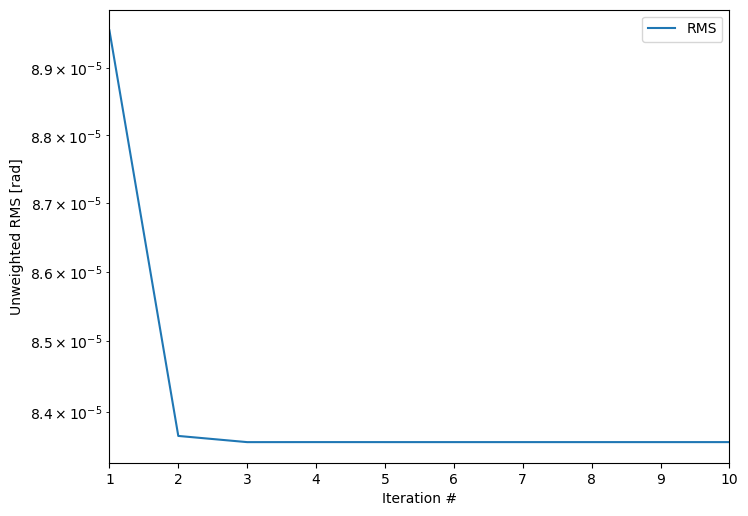

In [6]:
# plot RMS evolution through each iteration
radians = True
rms = np.array(rms) if radians else np.array(rms)*180/np.pi*3600 # convert RMS from radians to seconds of arc
plt.figure(figsize=(8,6), dpi=100)
plt.semilogy(np.arange(1,n_iter+1), rms, label = 'RMS')
plt.xlim(1, n_iter)
plt.xlabel('Iteration #')
plt.ylabel('Unweighted RMS [rad]') if radians else plt.ylabel('Unweighted RMS [Seconds of Arc]')
plt.legend()
plt.show()